In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')


![alt text](https://github.com/callysto/callysto-sample-notebooks/blob/master/notebooks/images/Callysto_Notebook-Banner_Top_06.06.18.jpg?raw=true)  


<h1 align='center'>Stats Can Notebook Template</h1>

<h4 align='center'>Laura Gutierrez Funderburk $\mid$ Stats Can Notebook</h4>

<h2 align='center'>Abstract</h2>

In this notebook we download a full dataset and plot multiple one-dimensional subsets of the data. 


Data set is obtained from https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1710005901 via ProductID 17-10-0059-01. 

This notebook uses our quick data set exploration application, and plots pie charts specific to the data set. 


In [2]:
%run -i ./StatsCan/helpers.py
%run -i ./StatsCan/scwds.py
%run -i ./StatsCan/sc.py

In [3]:
from ipywidgets import widgets, VBox, HBox, Button
from ipywidgets import Button, Layout, widgets
from IPython.display import display, Javascript, Markdown, HTML
import datetime as dt
import qgrid as q
import pandas as pd
import json
import datetime
import qgrid 
from tqdm import tnrange, tqdm_notebook
from time import sleep

grid_features = { 'fullWidthRows': True,
                  'syncColumnCellResize': True,
                  'forceFitColumns': True,
                  'enableColumnReorder': True,
                  'enableTextSelectionOnCells': True,
                  'editable': False,
                  'filterable': True,
                  'sortable': False,
                  'highlightSelectedRow': True}

def rerun_cell( b ):
    
    display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+1,IPython.notebook.get_selected_index()+3)'))    

    
def run_4cell( b ):
    
    display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+1,IPython.notebook.get_selected_index()+5)'))    

style = {'description_width': 'initial'}



<h2 align='center'>Downloading Stats Can Data</h2>

Press the button below to download the dataset https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1710005901 directly through StatsCan's API. 

In [4]:
# Fancy user interface to run cells below
DS_button = widgets.Button(
    button_style='success',
    description="Download Dataset", 
    layout=Layout(width='15%', height='30px'),
    style=style
)    
DS_button.on_click( run_4cell )

display(DS_button)

Button(button_style='success', description='Download Dataset', layout=Layout(height='30px', width='15%'), styl…

In [5]:
# # Download data 
# DATA SET PRODUCT ID  for internal use only. 
productId = '17-10-0059-01'

        
download_tables(str(productId))


df_fullDATA = zip_table_to_dataframe(productId)


# Clean up full dataset - remove internal use columns
cols = list(df_fullDATA.loc[:,'REF_DATE':'UOM'])+ ['SCALAR_FACTOR'] +  ['VALUE']
df_less = df_fullDATA[cols]
df_less2 = df_less.drop(["DGUID"], axis=1)

# Display only first five entries
df_less2.head()


PARSING DATA AS PANDAS DATAFRAME


,REF_DATE,GEO,Estimates,UOM,SCALAR_FACTOR,VALUE
0,1946-01-01,Canada,Births,Number,units,73273.0
1,1946-01-01,Canada,Deaths,Number,units,31629.0
2,1946-01-01,Canada,Marriages,Number,units,19648.0
3,1946-01-01,Prince Edward Island,Births,Number,units,598.0
4,1946-01-01,Prince Edward Island,Deaths,Number,units,272.0


In [6]:
# Display subsets found within data

# Get size of trimmed pandas
iteration_nr = df_less2.shape[1]
categories = []

# Get unique values in each subcategory
for i in range(iteration_nr-1):
    categories.append(df_less2.iloc[:,i].unique())
    
    
# Build a drop down menu for each subcategory, values displayed are those which were found in the loop above    
all_the_widgets = []
for i in range(len(categories)):
    if i==0:
        # First category contains start date
        a_category = widgets.Dropdown(
                value = categories[i][0],
                options = categories[i], 
                description ='Start Date:', 
                style = style, 
                disabled=False
            )
        b_category = widgets.Dropdown(
                value = categories[i][-1],
                options = categories[i], 
                description ='End Date:', 
                style = style, 
                disabled=False
            )
        all_the_widgets.append(a_category)
        all_the_widgets.append(b_category)
    elif i==1:
        # Base category: Store locations
        a_category = widgets.Dropdown(
                value = categories[i][0],
                options = categories[i], 
                description ='Location:', 
                style = style, 
                disabled=False
            )
        all_the_widgets.append(a_category)
    elif i==len(categories)-1:
        # Base category: Scalar factor
        a_category = widgets.Dropdown(
                value = categories[i][0],
                options = categories[i], 
                description ='Scalar factor:', 
                style = style, 
                disabled=False
            )
        all_the_widgets.append(a_category)
        
    elif i==len(categories)-2:
        # Base category: Units of measure
        a_category = widgets.Dropdown(
                value = categories[i][0],
                options = categories[i], 
                description ='Units of Measure :', 
                style = style, 
                disabled=False
            )
        all_the_widgets.append(a_category)
    else:
        # Non-base categories which may be added to datasets
        a_category = widgets.Dropdown(
                value = categories[i][0],
                options = categories[i], 
                description ='Subcategory ' + str(i), 
                style = style, 
                disabled=False
            )
        all_the_widgets.append(a_category)


## <h2 align='center'>Select Data Subsets: One-Dimensional Plotting</h2>


Use the user menu below to select a cateory within the full subset you are interested in exploring. 

Choose a starting and end date to plot results. 

If there is data available, it will appear under the headers. 

Be careful to select dataframes with actual data in them!. 

Use the Select Dataset button to help you preview the data. 

In [7]:
# Fancy user interface to explore datasets
# Button widget
CD_button = widgets.Button(
    button_style='success',
    description="Preview Dataset", 
    layout=Layout(width='15%', height='30px'),
    style=style
)    

# Connect widget to function - run subsequent cells
CD_button.on_click( run_4cell )

# user menu using categories found above
tab3 = VBox(children=[HBox(children=all_the_widgets[0:3]),
                      HBox(children=all_the_widgets[3:5]),
                      HBox(children=all_the_widgets[5:len(all_the_widgets)]),
                      CD_button])
tab = widgets.Tab(children=[tab3])
tab.set_title(0, 'Load Data Subset')
display(tab)

In [8]:
df_sub = df_less2[(df_less2["REF_DATE"]>=all_the_widgets[0].value) & 
                  (df_less2["REF_DATE"]<=all_the_widgets[1].value) &
                  (df_less2["GEO"]==all_the_widgets[2].value) &
                  (df_less2["UOM"]==all_the_widgets[-2].value) & 
                  (df_less2["SCALAR_FACTOR"]==all_the_widgets[-1].value) ]



df_sub.head()

,REF_DATE,GEO,Estimates,UOM,SCALAR_FACTOR,VALUE
0,1946-01-01,Canada,Births,Number,units,73273.0
1,1946-01-01,Canada,Deaths,Number,units,31629.0
2,1946-01-01,Canada,Marriages,Number,units,19648.0
36,1946-04-01,Canada,Births,Number,units,86530.0
37,1946-04-01,Canada,Deaths,Number,units,28938.0


In [9]:
# TO HANDLE THE REST OF THE COLUMNS, SIMPLY SUBSTITUTE VALUES 
col_name = df_sub.columns[2]

# This command will slice dataframe to get only the data we are interested in
df_sub_final = df_sub[(df_sub[col_name]==all_the_widgets[3].value)]

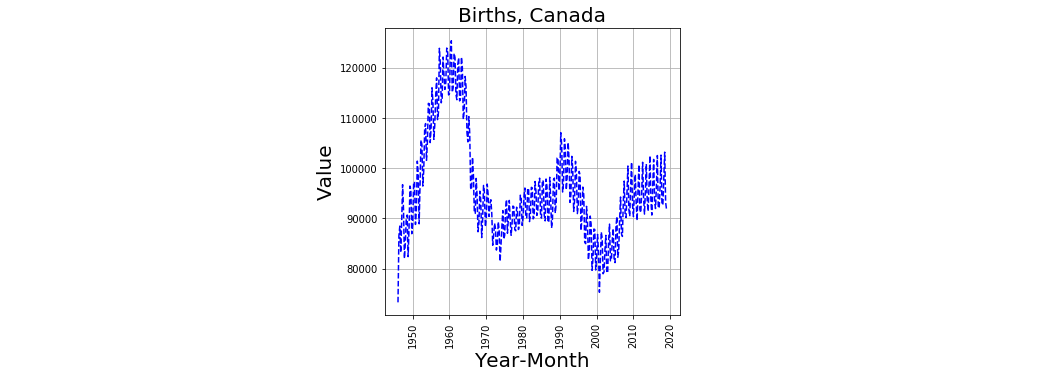

In [10]:

# Time to plot!
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

# Create "invisible" plot on the left - this is not necessary, but I like to center my plots in the notebook
# feels more aesthetically pleasing
fig1 = plt.figure(facecolor='w',figsize=(18,18))
plt.subplot(3, 3, 1)
plt.axis('off');

# Actual plot of time series
plt.subplot(3, 3, 2)
# Get start and end date, plot value found under "VALUE" command
plt.plot(df_sub_final["REF_DATE"],df_sub_final["VALUE"],'b--',label='Value')
plt.xlabel('Year-Month', fontsize=20)
plt.ylabel('Value',fontsize=20)
# Title changes depending on the subcategory explored
plt.title(str(all_the_widgets[3].value) + ", "+  str(all_the_widgets[2].value),fontsize=20)
plt.xticks(rotation=90)
plt.grid(True)

# Create "invisible" plot to the right - this is not necessary, but I like to center my plots in the notebook
# feels more aesthetically pleasing
plt.subplot(3, 3, 3);
plt.axis('off');


<h2 align='center'>Comparing proportion of Births and Deaths between a given year and 2018</h2>

Use the menu below to pick a year and a region and compare the proportion of births and deaths on that year. The year 2018 is displayed by default. 

In [11]:
# Pie charts!

# Dropdown button to get location
geo_dp2 = widgets.Dropdown(
    options = categories[1], 
    description ='Select location:', 
    style = style, 
    disabled=False
)

year_q = widgets.Dropdown(
    options = [1946 + i for i in range(73)], 
    description ='Select Year:', 
    style = style, 
    disabled=False
)


# Button widget to run subsequent cells
CD_button2 = widgets.Button(
    button_style='success',
    description="Preview Chart", 
    layout=Layout(width='15%', height='30px'),
    style=style
)    
CD_button2.on_click( rerun_cell )

# User interface menu
tab3 = VBox(children=[HBox(children=[geo_dp2,year_q]),
                      CD_button])
tab = widgets.Tab(children=[tab3])
tab.set_title(0, 'Preview Chart')
display(tab)

In [12]:


# This function takes as input a dataframe and a quarter, and returns a dataframe with data from that year only
def get_year_pd(dataframe,year):
    # Get REF_DATE value containing the year we are interested in
    df_year = dataframe.loc[(dataframe["REF_DATE"] == str(year))]
    # Rename column for easier readability
    df4 = df_year.rename(index=str, columns={"VALUE": year,"GEO":"Geography"})
    # Drop REF_DATE column - not needed anymore as we have a single year now
    df4 = df4.drop(columns="REF_DATE")

    return df4

# Use function to get first four quarters in 1990 and 2018
df_2010_f = get_year_pd(df_less2,str(year_q.value).split("-")[0] + "-01-01")
df_2010_s = get_year_pd(df_less2,str(year_q.value).split("-")[0] + "-04-01")
df_2010_t = get_year_pd(df_less2,str(year_q.value).split("-")[0] + "-07-01")
df_2010_fo = get_year_pd(df_less2,str(year_q.value).split("-")[0] + "-10-01")

df_2018_f = get_year_pd(df_less2,"2018-01-01")
df_2018_s = get_year_pd(df_less2,"2018-04-01")
df_2018_t = get_year_pd(df_less2,"2018-07-01")
df_2018_fo = get_year_pd(df_less2,"2018-10-01")

# Merge all quarters for 1990 into new dataframe
new_df10 = pd.merge(pd.merge(pd.merge(df_2010_f,df_2010_s),df_2010_t),df_2010_fo)
# Merge all quarters for 2018 into new dataframe
new_df18 = pd.merge(pd.merge(pd.merge(df_2018_f,df_2018_s),df_2018_t),df_2018_fo)
new_df = pd.merge(new_df10,new_df18)

# We are interested in the proportion of birth and death for two given years, on a quarterly basis
df3 = new_df.iloc[2:,:]
df4 = df3[df3["Estimates"]=="Births"]
df5 = df3[df3["Estimates"]=="Deaths"]

In [13]:
# Get region of interest from dropdown menu
whichprovince = geo_dp2.value

# Get dataframe containing data for that region
whichPo = new_df.loc[new_df['Geography']== whichprovince]

# Display dataframe
whichPo

,Geography,Estimates,UOM,SCALAR_FACTOR,1946-01-01,1946-04-01,1946-07-01,1946-10-01,2018-01-01,2018-04-01,2018-07-01,2018-10-01
0,Canada,Births,Number,units,73273.0,86530.0,88465.0,83203.0,92678.0,97706.0,103199.0,93223.0
1,Canada,Deaths,Number,units,31629.0,28938.0,26021.0,28770.0,75855.0,67997.0,66015.0,73763.0


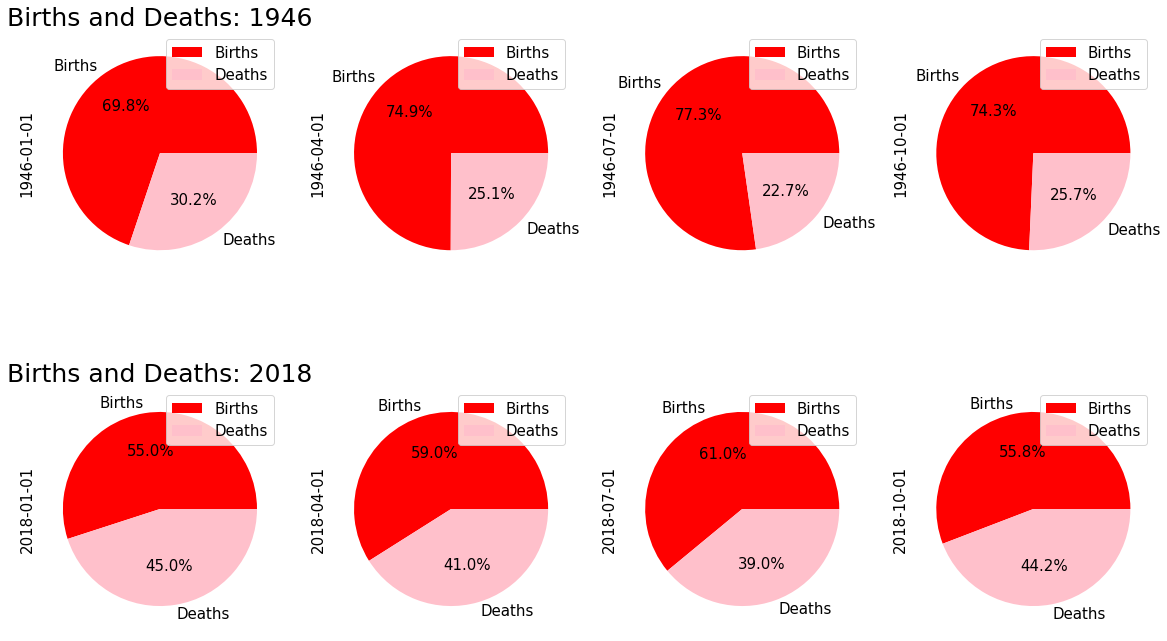

In [14]:
# Plotting piecharts

# Font size format
plt.rcParams.update({'font.size': 15})

# Handle case where data is not found
if whichPo.size==0:
    fig = plt.figure(figsize=(5,5))

    plt.text(0.5,0.5,"NO DATA FOUND",fontsize=25)
    
    plt.axis("Off")
    
else:
    # Assuming data exists for both time series
    # Assign each quarter to a variable - will use this later when plotting
    temp1 = whichPo[str(year_q.value).split("-")[0] + '-01-01']
    temp2 = whichPo[str(year_q.value).split("-")[0] + '-04-01']
    temp3 = whichPo[str(year_q.value).split("-")[0] + '-07-01']
    temp4 = whichPo[str(year_q.value).split("-")[0] + '-10-01']

    temp11 = whichPo['2018-01-01']
    temp21 = whichPo['2018-04-01']
    temp31 = whichPo['2018-07-01']
    temp41 = whichPo['2018-10-01']

    fig = plt.figure(figsize=(20,12))

    # Pie chart births and deaths 2018
    ax1 = fig.add_subplot(241)
    temp1.plot(kind = 'pie', subplots=True,
               legend=True, autopct='%2.1f%%', radius=1,labels=whichPo['Estimates'],colors = ['red', 'pink'])
    plt.title("Births and Deaths: " +str(year_q.value).split("-")[0] ,fontsize=25)
    


    # Use variables containing number of deaths and births and use .plot command 
    # Add subplot for each pie chart
    ax2 = fig.add_subplot(242)
    
    temp2.plot(kind = 'pie', subplots=True,
               legend=True, autopct='%1.1f%%', radius=1,labels=whichPo['Estimates'],colors = ['red', 'pink'])

    # Use variables containing number of deaths and births and use .plot command 
    # Add subplot for each pie chart
    ax3 = fig.add_subplot(243)
    temp3.plot(kind = 'pie', subplots=True,
               legend=True, autopct='%1.1f%%', radius=1,labels=whichPo['Estimates'],colors = ['red', 'pink'])

    # Use variables containing number of deaths and births and use .plot command 
    # Add subplot for each pie chart
    ax4 = fig.add_subplot(244)
    temp4.plot(kind = 'pie', subplots=True,
                legend=True, autopct='%1.1f%%', radius=1,labels=whichPo['Estimates'],colors = ['red', 'pink'])

    # Use variables containing number of deaths and births and use .plot command 
    # Add subplot for each pie chart
    ax5 = fig.add_subplot(245)
    plt.title("Births and Deaths: 2018",fontsize=25)

    temp11.plot(kind = 'pie', subplots=True,
               legend=True, autopct='%1.1f%%', radius=1,labels=whichPo['Estimates'],colors = ['red', 'pink'])

    # Use variables containing number of deaths and births and use .plot command 
    # Add subplot for each pie chart
    ax6 = fig.add_subplot(246)
    temp21.plot(kind = 'pie', subplots=True,
               legend=True, autopct='%1.1f%%', radius=1,labels=whichPo['Estimates'],colors = ['red', 'pink'])

    # Use variables containing number of deaths and births and use .plot command 
    # Add subplot for each pie chart
    ax7 = fig.add_subplot(247)
    temp31.plot(kind = 'pie', subplots=True,
               legend=True, autopct='%1.1f%%', radius=1,labels=whichPo['Estimates'],colors = ['red', 'pink'])

    # Use variables containing number of deaths and births and use .plot command 
    # Add subplot for each pie chart
    ax8 = fig.add_subplot(248)
    temp41.plot(kind = 'pie', subplots=True,
                legend=True, autopct='%1.1f%%', radius=1,labels=whichPo['Estimates'],colors = ['red', 'pink'])

    plt.show()

<h2 align='center'>References</h2>

Statistics Canada.  Table  17-10-0059-01   Estimates of the components of natural increase, quarterly


# ![alt text](https://github.com/callysto/callysto-sample-notebooks/blob/master/notebooks/images/Callysto_Notebook-Banners_Bottom_06.06.18.jpg?raw=true)